In [1]:
import glob 
import gc
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import scipy.io

##plotting
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.gridspec import GridSpec

from matplotlib import colors

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

##
## set the directories in which your copies of the data are in the dirs.py file
from dirs import wrfdir, basedir, coorddir, snoteldir, ucladir

## aesthetics
plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'


/global/homes/c/cowherd/.conda/envs/resilient-snowpack-estimation/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
## read in data
# make a nice snotel metadata geodataframe
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]

cdecmeta = pd.read_csv('/pscratch/sd/c/cowherd/cdecmeta.csv')
cdecmeta = cdecmeta[cdecmeta['ID'] != 'TST']

cdec_gdf = gpd.GeoDataFrame(data = {'site_name':cdecmeta['Station Name'],
                                     'elev': cdecmeta['ElevationFeet'],
                                     'site_number':cdecmeta.index,
                                     'state':cdecmeta.index,
                                     'namestr':cdecmeta.ID,
                                     'startdt':cdecmeta.index}, geometry = gpd.points_from_xy(cdecmeta.Longitude, cdecmeta.Latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{basedir}data/huc2.shp')
coords = xr.open_dataset(f'{coorddir}wrfinput_d02')
states = gpd.read_file(f'{basedir}data/cb_2018_us_state_5m.shp')
## ucla annual maximum extracted data
maxfiles = glob.glob(ucladir + 'max_values_*.nc')
data = xr.open_mfdataset(maxfiles, combine = 'nested', concat_dim = 'year')

pillows = gpd.pd.concat([snotel_no_ak, cdec_gdf], ignore_index = True)
pillows = gpd.GeoDataFrame(pillows, geometry='geometry', crs=pillows.crs)
def assign_source(state):
    if type(state) == int:
        return 'CDEC'
    elif type(state) == str:
        return 'SNOTEL'
    else:
        return None  

pillows['network'] = pillows['state'].apply(assign_source)

/tmp/ipykernel_2013823/3369425741.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [3]:
## for the UCLA data, the grids are based on degrees so we must area-weight by latitude
pixel_size_deg = 0.004444
lat = data.lat
pixel_areas_deg2 = np.cos(np.radians(lat)) * pixel_size_deg**2
Y,X = np.meshgrid(data.lat, data.lon)
num_repetitions = 5175
areas_arr = np.tile(pixel_areas_deg2, (num_repetitions, 1))
earth_radius_meters = 6.371e6
pixel_areas_meters2 = pixel_areas_deg2 * (earth_radius_meters**2)


In [4]:
ts_snowy = []
ts_land = []
ts_snotel = []
ts_land_sd = []
ts_snowy_sd = []
years = []
maskfile = xr.open_dataset(maxfiles[0])
mask = maskfile.maxSWE > 0.1

for fn in maxfiles:
    data = xr.open_dataset(fn)
    area_weighted = data.maxSWE * areas_arr / np.mean(areas_arr[0])
    snow_only = area_weighted.where(mask)
    ts_snowy.append(np.nanmean(snow_only))
    ts_land.append(np.nanmean(area_weighted))
    ts_snowy_sd.append(np.nanstd(snow_only))
    ts_land_sd.append(np.nanstd(area_weighted))
    gc.collect()
    years.append(int(fn.split('_values_')[-1][0:4]))
data = {'ts_snowy': ts_snowy, 'ts_land': ts_land}
ucladf = pd.DataFrame(data, index=years)
ucladf.sort_index(inplace=True)

In [5]:
## load snotel locations from Fang 2022 paper
# mat_data_best = scipy.io.loadmat(f'{ucladir}SNOTEL_SWE_peak_reanalysis_best_match.mat')
# ucla_snotel_m = mat_data_best['Peak_SWE_re_post'] * 1000
# ucla_snotel_m_ts = np.nanmean(ucla_snotel_m,axis=0)
ucla_snotel_data = np.load(f'../../ucla_snotel_data.npy', allow_pickle = True)
ucla_cdec_data = np.load(f'../../ucla_cdec_data.npy', allow_pickle = True)
ucla_cdec_data = ucla_cdec_data.flatten()[0]['SWE_Reanalysis_post']
ucla_snotel_data = ucla_snotel_data.flatten()[0]['SWE_Reanalysis_post']
ucla_pillow = np.concatenate((ucla_cdec_data, ucla_snotel_data), axis=2) * 1000
ucla_pillow_m_ts = np.nanmean(np.nanmax(ucla_pillow, axis = 0), axis = 1)

ucla_years = range(1985,2022)

/tmp/ipykernel_2013823/4121824481.py:10: RuntimeWarning: All-NaN slice encountered
  ucla_pillow_m_ts = np.nanmean(np.nanmax(ucla_pillow, axis = 0), axis = 1)


In [6]:
mapvalues = np.load(f'{basedir}data/wrfmaps.npy', allow_pickle = 'True').flatten()[0]
ts = np.load(f'{basedir}data/model_ts.npy', allow_pickle = True).flatten()[0]
landmask0 = coords['LANDMASK'][0] > 0
landmask1 = coords['HGT'][0] > 10
landmask2 = landmask1 | landmask0

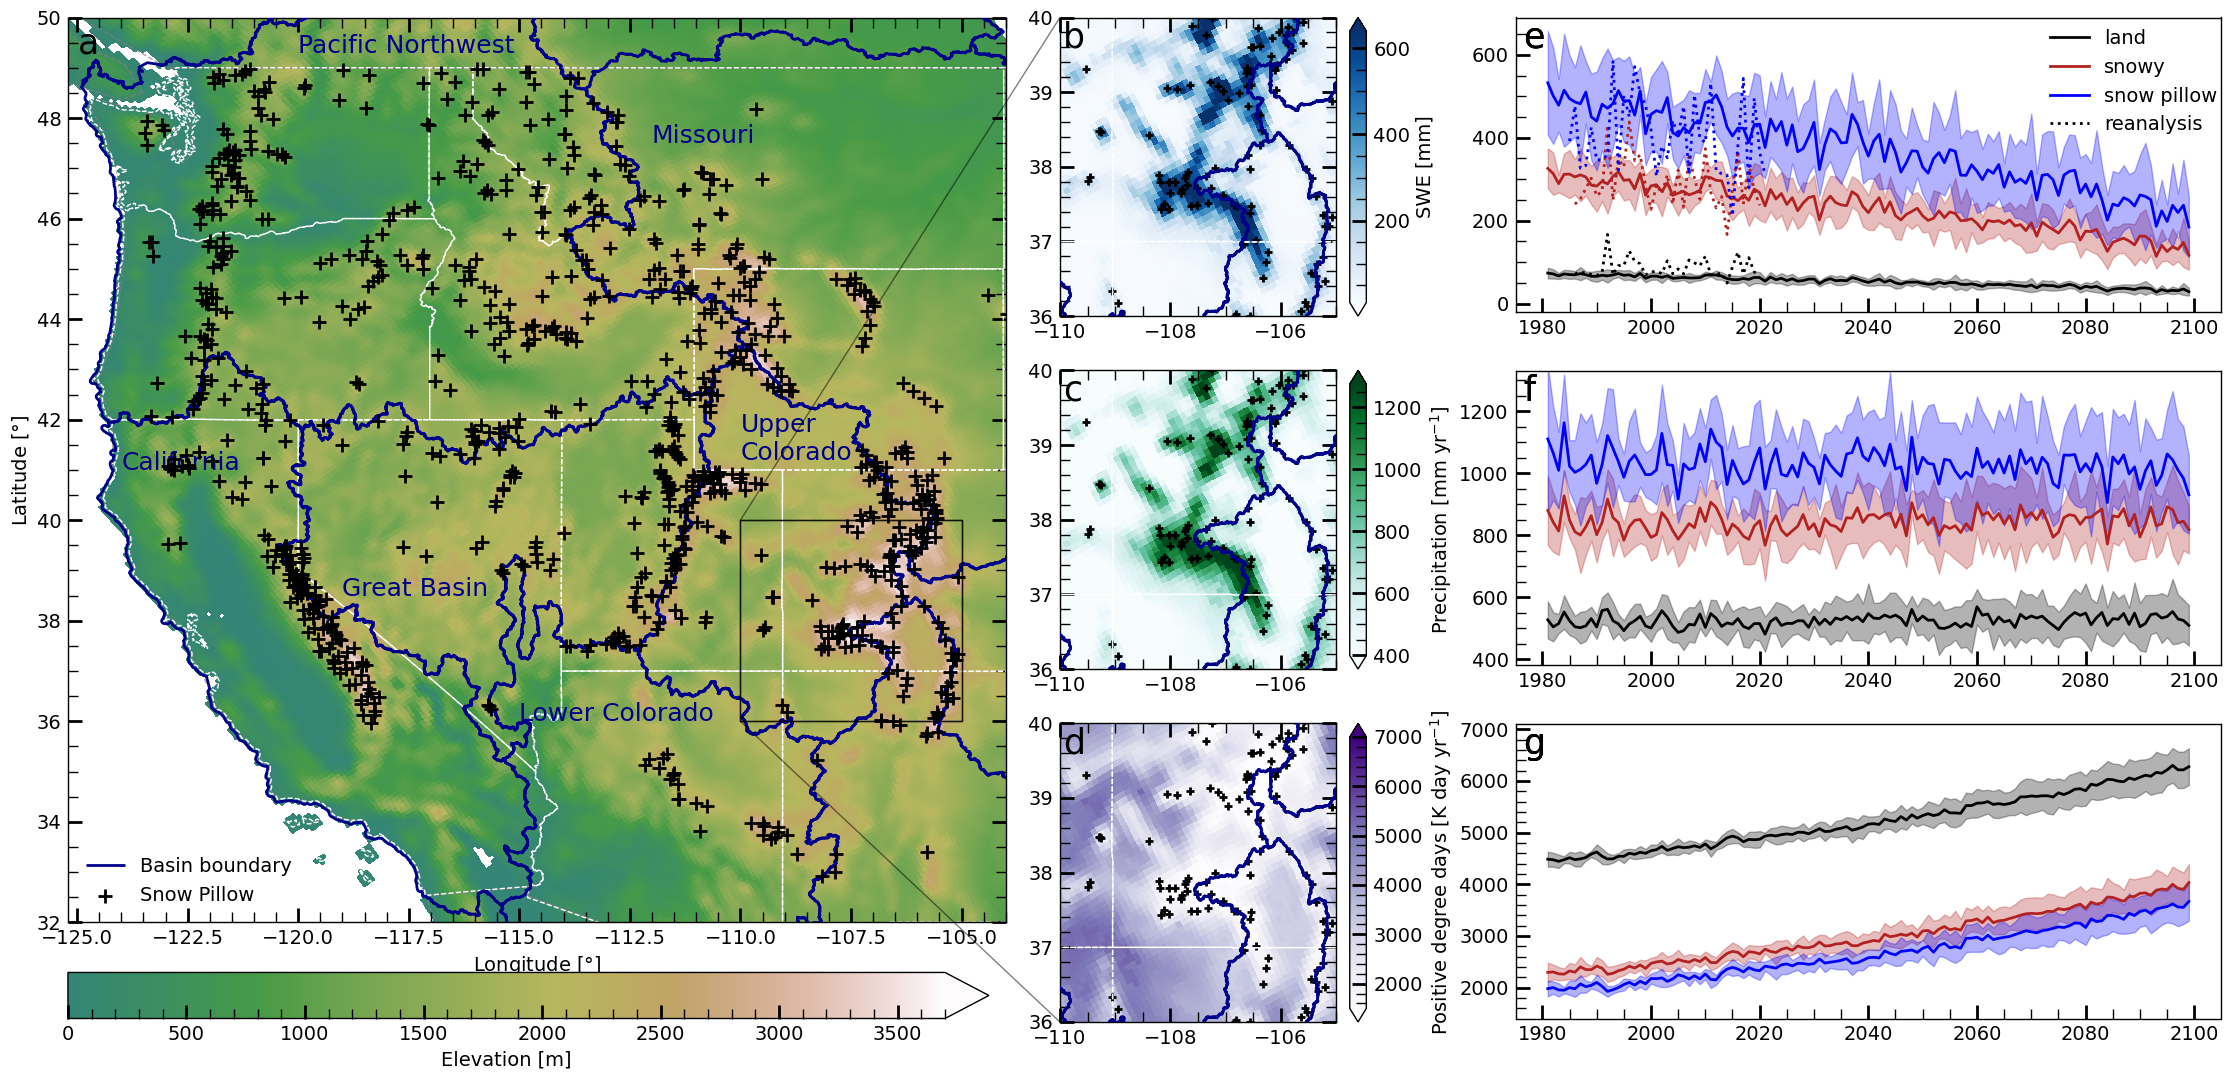

In [11]:
LETTERLABELS = True
def label_axis(axis, letter):
    axis.text(.01, .99, letter, ha='left', va='top', transform=axis.transAxes, fontsize = 25)
    return
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(30, 13))
gs = GridSpec(3, 3, figure=fig, width_ratios=[2,.1, 1.1])

ax_large = fig.add_subplot(gs[:, 0])

# Smaller subplots stacked on the right
axs_small = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(2, 3)]


''' colors
'''
categories = ['land', 'landsnow', 'snotel']
types = ['snow', 'prec', 't2']
#catcolors = ['black','#DA7800','#0000FF']
catcolors = ['black','firebrick','#0000FF']

# DA7800, c1272d
# values, colormap, index, vmin, vmax, label, ts) 
data = {'swe': [mapvalues['snow'], cm.Blues, 0, 10, 640, r'SWE [mm]'],
        'prec': [mapvalues['prec'], cm.BuGn, 1, 400, 1275,r'Precipitation [mm yr$^{-1}$]'],
        't2': [mapvalues['t2'], cm.Purples, 2, 1500,7000,r'Positive degree days [K day yr$^{-1}$]'],
       }
plotranges =  {'swe': [-20, 690],
        'prec':[380, 1330],
        't2': [1400,7100],
       }
basincolor = 'darkblue'
sncolor='k'
cmap = cm.gist_earth

new_cmap = cmap(np.arange(80,cmap.N))

new_cmap = colors.ListedColormap(new_cmap)

basinlabels = [[-120,49.3,'Pacific Northwest'],
                [-110,41.2,'Upper\nColorado'],
               [-115,36,'Lower Colorado'],
               [-119,38.5,'Great Basin'],
               [-124,41,'California'],
               [-112,47.5,'Missouri']]
               
cb = ax_large.pcolormesh(coords['XLONG'][0], coords['XLAT'][0], coords['HGT'][0].where(landmask2), cmap = new_cmap, vmin = 0, vmax = 3700)
cbar = plt.colorbar(cb, ax =ax_large, orientation = 'horizontal', fraction=0.046, pad=0.05, extend = 'max')
cbar.set_label('Elevation [m]')


world.boundary.plot(ax=ax_large, linewidth =1, color = 'gray', alpha = 0.7, linestyle = '--')
huc2.boundary.plot(ax=ax_large, linewidth = 2, color = basincolor, label = 'Basin boundary', zorder =3 )
pillows.plot(ax=ax_large, marker = '+', markersize = 100, color = sncolor, label = 'Snow Pillow', zorder = 4)
#snotel_no_ak.plot(ax=ax_large, marker = '+', markersize = 100, color = sncolor, label = 'SNOTEL station', zorder = 4)
states.boundary.plot(ax=ax_large, linewidth =1, color = 'white', alpha = 1, linestyle = '--')

for entry in basinlabels:
    ax_large.text(entry[0], entry[1], entry[2], fontsize=18, color = basincolor)
    
x1, x2, y1, y2 = -110, -105, 36 ,40
j = 0
if LETTERLABELS: label_axis(ax_large, 'a')
for key, info in data.items():
    dataset = info[0]
    cmap = info[1]
    idx = info[2]
    vmin = info[3]
    vmax = info[4]
    label = info[5]
    # Calculate inset axes position based on idx

    axins = ax_large.inset_axes([1.04, 0.67 - 0.39 * idx, 0.33, 0.33])
    cb = axins.pcolormesh(coords['XLONG'][0], coords['XLAT'][0], dataset, cmap = cmap, vmin = vmin, vmax = vmax)
    pillows.plot(ax=axins, marker = '+',color = sncolor)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    if LETTERLABELS: label_axis(axins, chr(ord('`') + j + 2))

    states.boundary.plot(ax=axins, linewidth =1, color = 'white', alpha = 1, linestyle = '--')
    huc2.boundary.plot(ax=axins, linewidth = 2, color = basincolor, zorder =3 )


    cax = axins.inset_axes([1.05, 0, 0.06, 1])        
    cbar = plt.colorbar(cb, cax=cax, pad=0.1, orientation='vertical',
                         extend='both', label = label)
    # cbar.set_ticklabels([])

     
    a,b = ax_large.indicate_inset_zoom(axins, edgecolor="black")  
    for line in b:
        line.set(visible = False)
    if idx == 0:
        b[1].set(visible = True)
    if idx == 2:
        b[0].set(visible = True)
    
    years = range(1981, 2100)
    
    if key == 'swe': tskey = 'snow'
    else: tskey = key
    
    
    for category, color in zip(categories, catcolors):
        if category == 'land': catlabel = 'land'
        elif category == 'landsnow': catlabel = 'snowy'
        elif category == 'snotel': catlabel = 'snow pillow'
        time_series = ts[category][tskey]
        mean = np.mean(time_series, axis=0)[1:-1]
        std = np.std(time_series, axis=0)[1:-1]
        axs_small[j].fill_between(years, mean - std, mean + std, color=color, alpha=0.3)
        axs_small[j].plot(years,mean, color=color, label=catlabel)
        axs_small[j].yaxis.tick_left() 
        axs_small[j].yaxis.set_label_position('left')
        axs_small[j].xaxis.set_ticks_position('bottom')
        if LETTERLABELS: label_axis(axs_small[j], chr(ord('`') + j + 5))
        
    if key == 'swe':
        axs_small[j].plot(ucladf.index, ucladf.ts_snowy * 1000, linestyle = ':', color = catcolors[1])
        axs_small[j].plot(ucladf.index, ucladf.ts_land * 1000, linestyle = ':', color = catcolors[0], label = 'reanalysis')
        axs_small[j].plot(ucla_years, ucla_pillow_m_ts, linestyle = ':', color = catcolors[2])
            
    axs_small[j].set_ylim((plotranges[key][0], plotranges[key][1]))
    # axs_small[j].set_ylabel(label)
    axs_small[0].legend(frameon = False, ncol =1, loc = 'upper right', bbox_to_anchor = (1.02,1.02))
    j+=1
    

ax_large.set_xlabel(r'Longitude [$\degree$]')
ax_large.set_ylabel(r'Latitude [$\degree$]')

ax_large.set_xlim((-125.2,-104))
ax_large.set_ylim((32,50))
ax_large.legend(loc = 'lower left')

plt.savefig(f'{basedir}/figures/fig1.jpg', dpi = 400)
plt.show()